In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import os
import requests

Using TensorFlow backend.


<Response [200]>

In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

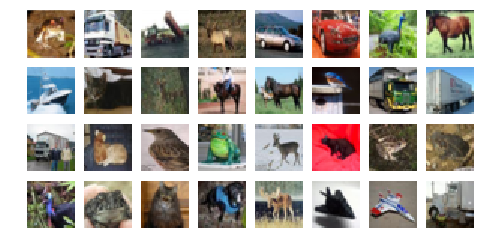

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

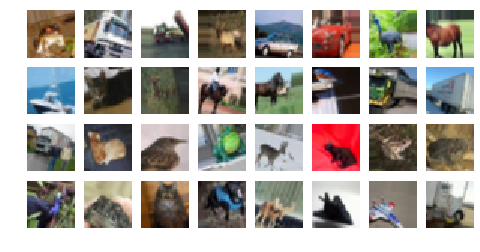

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

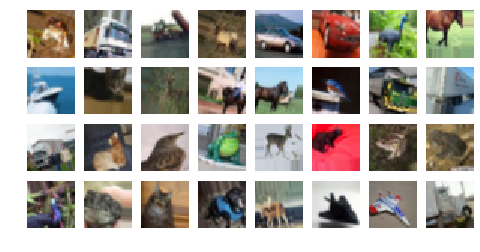

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import  EarlyStopping,ReduceLROnPlateau
import os

In [9]:
batch_size = 128 
num_classes = 10 
epochs = 50

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
from keras.applications.densenet import DenseNet121
from keras.models import Model

model = DenseNet121(include_top=False, weights=None, input_shape=(32,32,3))
output=Flatten()(model.output)
output = Dropout(0.5)(output)
output_layer = Dense(num_classes, activation='softmax', name='softmax')(output)
model = Model(inputs=model.input, outputs=output_layer)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001,decay=1e-5),
              metrics=['accuracy'])

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),callbacks=[learning_rate_reduction])



Epoch 1/50
390/390 [==============================] - 56s 144ms/step - loss: 1.7070 - accuracy: 0.4082 - val_loss: 9.1619 - val_accuracy: 0.1365
Epoch 2/50
390/390 [==============================] - 41s 105ms/step - loss: 1.4365 - accuracy: 0.5061 - val_loss: 3.0544 - val_accuracy: 0.1372
Epoch 3/50
390/390 [==============================] - 41s 105ms/step - loss: 1.4088 - accuracy: 0.5228 - val_loss: 1.4816 - val_accuracy: 0.4683
Epoch 4/50
390/390 [==============================] - 41s 105ms/step - loss: 1.1990 - accuracy: 0.5833 - val_loss: 11.9932 - val_accuracy: 0.3697
Epoch 5/50
390/390 [==============================] - 41s 105ms/step - loss: 1.0692 - accuracy: 0.6272 - val_loss: 1.3065 - val_accuracy: 0.5730
Epoch 6/50
390/390 [==============================] - 41s 105ms/step - loss: 0.9705 - accuracy: 0.6629 - val_loss: 1.3363 - val_accuracy: 0.5787
Epoch 7/50
390/390 [==============================] - 41s 105ms/step - loss: 0.9389 - accuracy: 0.6764 - val_loss: 2.9676 - val_

In [13]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))



10000/10000 [==============================] - 6s 576us/step
Test: accuracy = 0.827200  ;  loss = 0.835094


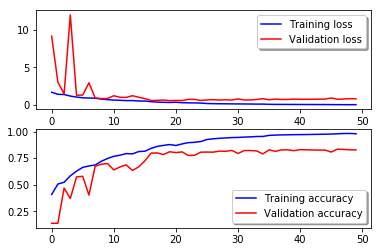

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()
